In [39]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, utils
from tensorflow.data import Dataset
from tensorflow.keras.losses import CategoricalFocalCrossentropy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, matthews_corrcoef

# ===================== CONFIGURACIÓN =====================
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Parámetros del modelo
IMAGE_SIZE = 512
CHANNELS = 11  # 3 canales RGB + 8 morfométricos
NUM_CLASSES = 4  # Fondo + 3 tipos de remoción
BATCH_SIZE = 4
EPOCHS = 50
LEARNING_RATE = 3e-5

# Rutas (¡AJUSTAR ESTAS!)
DATA_BASE_PATH = "E:/Memoria/CNN/Datasets_Final/dataset_multi"
MODEL_SAVE_PATH = r"E:\Memoria\CNN\Modelos_finales\deeplabv3multiclase.keras"

In [40]:
# ===================== CARGA DE DATOS =====================
def load_split(base_path, split, means=None, stds=None):
    """Carga un split completo (train/val/test)"""
    images_dir = os.path.join(base_path, split, "images")
    masks_dir = os.path.join(base_path, split, "masks")
    
    # Cargar y ordenar archivos
    image_files = sorted([os.path.join(images_dir, f) for f in os.listdir(images_dir) if f.endswith('.npy')])
    mask_files = sorted([os.path.join(masks_dir, f) for f in os.listdir(masks_dir) if f.endswith('.npy')])
    
    # Cargar datos
    images = np.array([np.load(f) for f in image_files], dtype=np.float32)  # Convertir a float32
    masks = np.array([np.load(f) for f in mask_files])
    
    # Normalización usando estadísticas del train
    if means is not None and stds is not None:
        images = (images - means) / stds
    
    # One-hot encoding para máscaras
    masks = tf.one_hot(masks.astype(np.int32), depth=NUM_CLASSES).numpy()
    
    return images, masks

# Cargar primero el train para calcular estadísticas
X_train, y_train = load_split(DATA_BASE_PATH, "train")
train_means = np.mean(X_train, axis=(0,1,2))
train_stds = np.std(X_train, axis=(0,1,2))

# Recargar todos los splits con normalización consistente
X_train, y_train = load_split(DATA_BASE_PATH, "train", train_means, train_stds)
X_val, y_val = load_split(DATA_BASE_PATH, "val", train_means, train_stds)
X_test, y_test = load_split(DATA_BASE_PATH, "test", train_means, train_stds)


In [ ]:
# ===================== CÁLCULO DE PESOS =====================
def calculate_class_weights(masks):
    class_counts = np.zeros(NUM_CLASSES)
    for mask in masks:
        cls, counts = np.unique(np.argmax(mask, axis=-1), return_counts=True)
        for c, cnt in zip(cls, counts):
            class_counts[c] += cnt

    # Pesos inversamente proporcionales + suavizado exponencial
    weights = 1 / (class_counts ** 0.75) 
    return weights / np.sum(weights) * NUM_CLASSES  # Escalar

class_weights = calculate_class_weights(y_train)
print("Nuevos pesos:", class_weights)

Pesos calculados: [0.00458703 0.27324145 0.52329437 0.19887715]


In [42]:
# ===================== FUNCIÓN DE PÉRDIDA =====================
class WeightedFocalLoss(CategoricalFocalCrossentropy):
    def __init__(self, alpha, gamma=2.0, name='weighted_focal_loss'):
        super().__init__(alpha=alpha, gamma=gamma, name=name)
        
    def call(self, y_true, y_pred):
        return super().call(y_true, y_pred)

In [43]:
# ===================== AUMENTO DE DATOS =====================
def augment_data(image, mask):
    # Flip aleatorio
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)
    
    # Rotación de 90° (alternativa sin tensorflow_addons)
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)  # Número de rotaciones de 90°
    image = tf.image.rot90(image, k=k)
    mask = tf.image.rot90(mask, k=k)
    
    # Ajuste de brillo solo para canales RGB
    if tf.random.uniform(()) > 0.5:
        rgb_channels = image[..., :3] * tf.random.uniform([], 0.9, 1.1, dtype=image.dtype)
        image = tf.concat([rgb_channels, image[..., 3:]], axis=-1)
    
    return image, mask

In [44]:

# ===================== ARQUITECTURA CBAM =====================
def cbam_block(inputs, reduction_ratio=8):
    # Channel attention
    channel = layers.GlobalAveragePooling2D()(inputs)
    channel = layers.Dense(inputs.shape[-1]//reduction_ratio, activation='relu')(channel)
    channel = layers.Dense(inputs.shape[-1], activation='sigmoid')(channel)
    channel = layers.Reshape((1, 1, inputs.shape[-1]))(channel)
    
    # Spatial attention
    spatial = layers.Concatenate(axis=-1)([
        layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(inputs),
        layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(inputs)
    ])
    spatial = layers.Conv2D(1, 7, padding='same', activation='sigmoid')(spatial)
    
    return layers.Multiply()([layers.Multiply()([inputs, channel]), spatial])

In [45]:
# ===================== ARQUITECTURA DEEPLABV3+ =====================
def CBAM_DeepLabV3Plus(input_shape=(512, 512, 11), num_classes=4):
    # Backbone (Xception modificado para 11 canales)
    inputs = layers.Input(shape=input_shape)
    
    # ------------------------- ENCODER -------------------------
    # Bloque 1 (512x512 -> 256x256)
    x = layers.Conv2D(32, 3, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    # Bloque 2 (256x256 -> 128x128) -> Capturar low-level features aquí
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)  # Salida: 128x128
    low_level = x  # ¡Capturamos las características de bajo nivel aquí!
    
    # Bloques posteriores (128x128 -> 64x64 -> 32x32)
    for filters in [128, 256]:
        x = layers.Conv2D(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.MaxPooling2D(pool_size=2)(x)
    
    # ------------------------- ASPP CON CBAM -------------------------
    def aspp_block(inputs):
        rates = [1, 6, 12, 18]
        branches = []
        for rate in rates:
            branch = layers.Conv2D(256, 3, dilation_rate=rate, padding='same', activation='relu')(inputs)
            branch = cbam_block(branch)
            branches.append(branch)
        
        # Pooling global
        pooled = layers.GlobalAveragePooling2D()(inputs)
        pooled = layers.Reshape((1, 1, 256))(pooled)
        pooled = layers.Conv2D(256, 1, activation='relu')(pooled)
        pooled = layers.UpSampling2D(size=inputs.shape[1:3], interpolation='bilinear')(pooled)
        
        return layers.Concatenate()(branches + [pooled])
    
    x = aspp_block(x)
    x = layers.Conv2D(256, 1, activation='relu')(x)
    
    # ------------------------- DECODER -------------------------
    # 1. Upsample ASPP output a 128x128 (misma resolución que low_level)
    x = layers.UpSampling2D(size=(4,4), interpolation='bilinear')(x)  # 32x32 -> 128x128
    
    # 2. Procesar low-level features
    low_level = layers.Conv2D(48, 1, activation='relu')(low_level)  # Reducir canales
    low_level = cbam_block(low_level)
    
    # 3. Concatenar (ambos ahora en 128x128)
    x = layers.Concatenate()([x, low_level])
    
    # 4. Convolución post-concatenación
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = cbam_block(x)
    
    # 5. Upsample final a 512x512
    x = layers.UpSampling2D(size=(4,4), interpolation='bilinear')(x)
    
    # Salida
    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(x)
    
    return Model(inputs=inputs, outputs=outputs)

In [46]:
model = CBAM_DeepLabV3Plus()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_116 (Conv2D) │ (None, 256, 256,  │      3,200 │ input_layer_7[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_116[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_28       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_117 (Conv2D) │ (None, 256, 256,  │     18,496 │ activation_28[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_117[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_29       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, 128, 128,  │          0 │ activation_29[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_118 (Conv2D) │ (None, 128, 128,  │     73,856 │ max_pooling2d_21… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_118[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_30       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_22    │ (None, 64, 64,    │          0 │ activation_30[0]… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_119 (Conv2D) │ (None, 64, 64,    │    295,168 │ max_pooling2d_22… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_119[0][0]  │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_31       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_23    │ (None, 32, 32,    │          0 │ activation_31[0]… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_120 (Conv2D) │ (None, 32, 32,    │    590,080 │ max_pooling2d_23

 Total params: 3,936,092 (15.01 MB)

 Trainable params: 3,935,132 (15.01 MB)

 Non-trainable params: 960 (3.75 KB)

In [47]:
# ===================== ENTRENAMIENTO =====================
# Preparar datasets
train_dataset = Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.map(augment_data).shuffle(100).batch(BATCH_SIZE).prefetch(2)

val_dataset = Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)
test_dataset = Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

# Construir y compilar modelo
model = CBAM_DeepLabV3Plus()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=WeightedFocalLoss(alpha=class_weights),
    metrics=[
        tf.keras.metrics.OneHotMeanIoU(num_classes=NUM_CLASSES, name='iou'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_iou',
        patience=20,
        mode='max',
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        MODEL_SAVE_PATH,
        save_best_only=True,
        monitor='val_iou',
        mode='max'
    ),
    tf.keras.callbacks.TensorBoard(log_dir='logs')
]

# Entrenamiento
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 52s 5s/step - iou: 0.0299 - loss: 0.0126 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_iou: 0.1128 - val_loss: 0.0130 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - iou: 0.0901 - loss: 0.0137 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_iou: 0.1303 - val_loss: 0.0130 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - iou: 0.0812 - loss: 0.0135 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_iou: 0.1123 - val_loss: 0.0130 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - iou: 0.0978 - loss: 0.0136 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_iou: 0.1322 - val_loss: 0.0130 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - iou: 0.1212 - loss: 0.0114 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_iou: 0.1556 - val_loss: 

In [48]:
# ===================== EVALUACIÓN =====================
# Evaluar en test
test_results = model.evaluate(test_dataset)
print("\nResultados en Test:")
print(f"Loss: {test_results[0]:.4f}")
print(f"IoU: {test_results[1]:.4f}")
print(f"Precision: {test_results[2]:.4f}")
print(f"Recall: {test_results[3]:.4f}")

# Generar reporte completo
y_pred = model.predict(X_test)
y_true = np.argmax(y_test, axis=-1).flatten()
y_pred = np.argmax(y_pred, axis=-1).flatten()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Fondo', 'Remoción 1', 'Remoción 2', 'Remoción 3']))

print("\nMatthews Correlation Coefficient:", matthews_corrcoef(y_true, y_pred))

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 773ms/step - iou: 0.2869 - loss: 0.0169 - precision: 0.9775 - recall: 0.1090

Resultados en Test:
Loss: 0.0185
IoU: 0.2582
Precision: 0.9733
Recall: 0.1254
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step

Classification Report:


c:\Users\yuuky\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yuuky\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yuuky\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

       Fondo       0.95      0.89      0.92   4631647
  Remoción 1       0.00      0.00      0.00    124412
  Remoción 2       0.04      0.39      0.06     16164
  Remoción 3       0.19      0.44      0.26    208513

    accuracy                           0.84   4980736
   macro avg       0.29      0.43      0.31   4980736
weighted avg       0.89      0.84      0.86   4980736


Matthews Correlation Coefficient: 0.19130675950914386


In [49]:
# ===================== VISUALIZACIÓN DE PREDICCIONES =====================
def visualize_predictions(model, X_test, y_test, num_samples=3):
    """Visualiza las predicciones del modelo junto con las máscaras verdaderas."""
    sample_indices = np.random.choice(len(X_test), num_samples, replace=False)
    
    for idx in sample_indices:
        image = X_test[idx]
        true_mask = y_test[idx]
        pred_mask = model.predict(image[np.newaxis, ...])[0]
        pred_mask = np.argmax(pred_mask, axis=-1)  # Convertir one-hot a índices
        
        plt.figure(figsize=(18, 6))
        
        # Imagen original (primeros 3 canales como RGB)
        plt.subplot(1, 3, 1)
        img_rgb = image[..., :3]
        img_rgb = (img_rgb - img_rgb.min()) / (img_rgb.max() - img_rgb.min())  # Normalizar
        img_rgb = (img_rgb * 255).astype(np.uint8)  # Escalar a [0, 255]
        plt.imshow(img_rgb)
        plt.title("Imagen Original")
        plt.axis("off")
        
        # Máscara verdadera
        plt.subplot(1, 3, 2)
        plt.imshow(np.argmax(true_mask, axis=-1), cmap="jet", vmin=0, vmax=NUM_CLASSES-1)
        plt.title("Máscara Verdadera")
        plt.axis("off")
        
        # Predicción del modelo
        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask, cmap="jet", vmin=0, vmax=NUM_CLASSES-1)
        plt.title("Predicción del Modelo")
        plt.axis("off")
        
        plt.show()

# ===================== GRÁFICOS DE COMPORTAMIENTO DEL ENTRENAMIENTO =====================
def plot_training_history(history):
    """Grafica la precisión y la pérdida durante el entrenamiento y la validación."""
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_precision = history.history['precision']
    val_precision = history.history['val_precision']
    train_recall = history.history['recall']
    val_recall = history.history['val_recall']
    train_iou = history.history['iou']
    val_iou = history.history['val_iou']
    
    plt.figure(figsize=(18, 12))
    
    # Gráfico de Precisión
    plt.subplot(2, 2, 1)
    plt.plot(train_precision, label='Precisión (Entrenamiento)')
    plt.plot(val_precision, label='Precisión (Validación)')
    plt.title('Precisión durante el Entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()
    
    # Gráfico de Pérdida
    plt.subplot(2, 2, 2)
    plt.plot(train_loss, label='Pérdida (Entrenamiento)')
    plt.plot(val_loss, label='Pérdida (Validación)')
    plt.title('Pérdida durante el Entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    
    # Gráfico de Recall
    plt.subplot(2, 2, 3)
    plt.plot(train_recall, label='Recall (Entrenamiento)')
    plt.plot(val_recall, label='Recall (Validación)')
    plt.title('Recall durante el Entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Recall')
    plt.legend()
    
    # Gráfico de IoU
    plt.subplot(2, 2, 4)
    plt.plot(train_iou, label='IoU (Entrenamiento)')
    plt.plot(val_iou, label='IoU (Validación)')
    plt.title('IoU durante el Entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('IoU')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

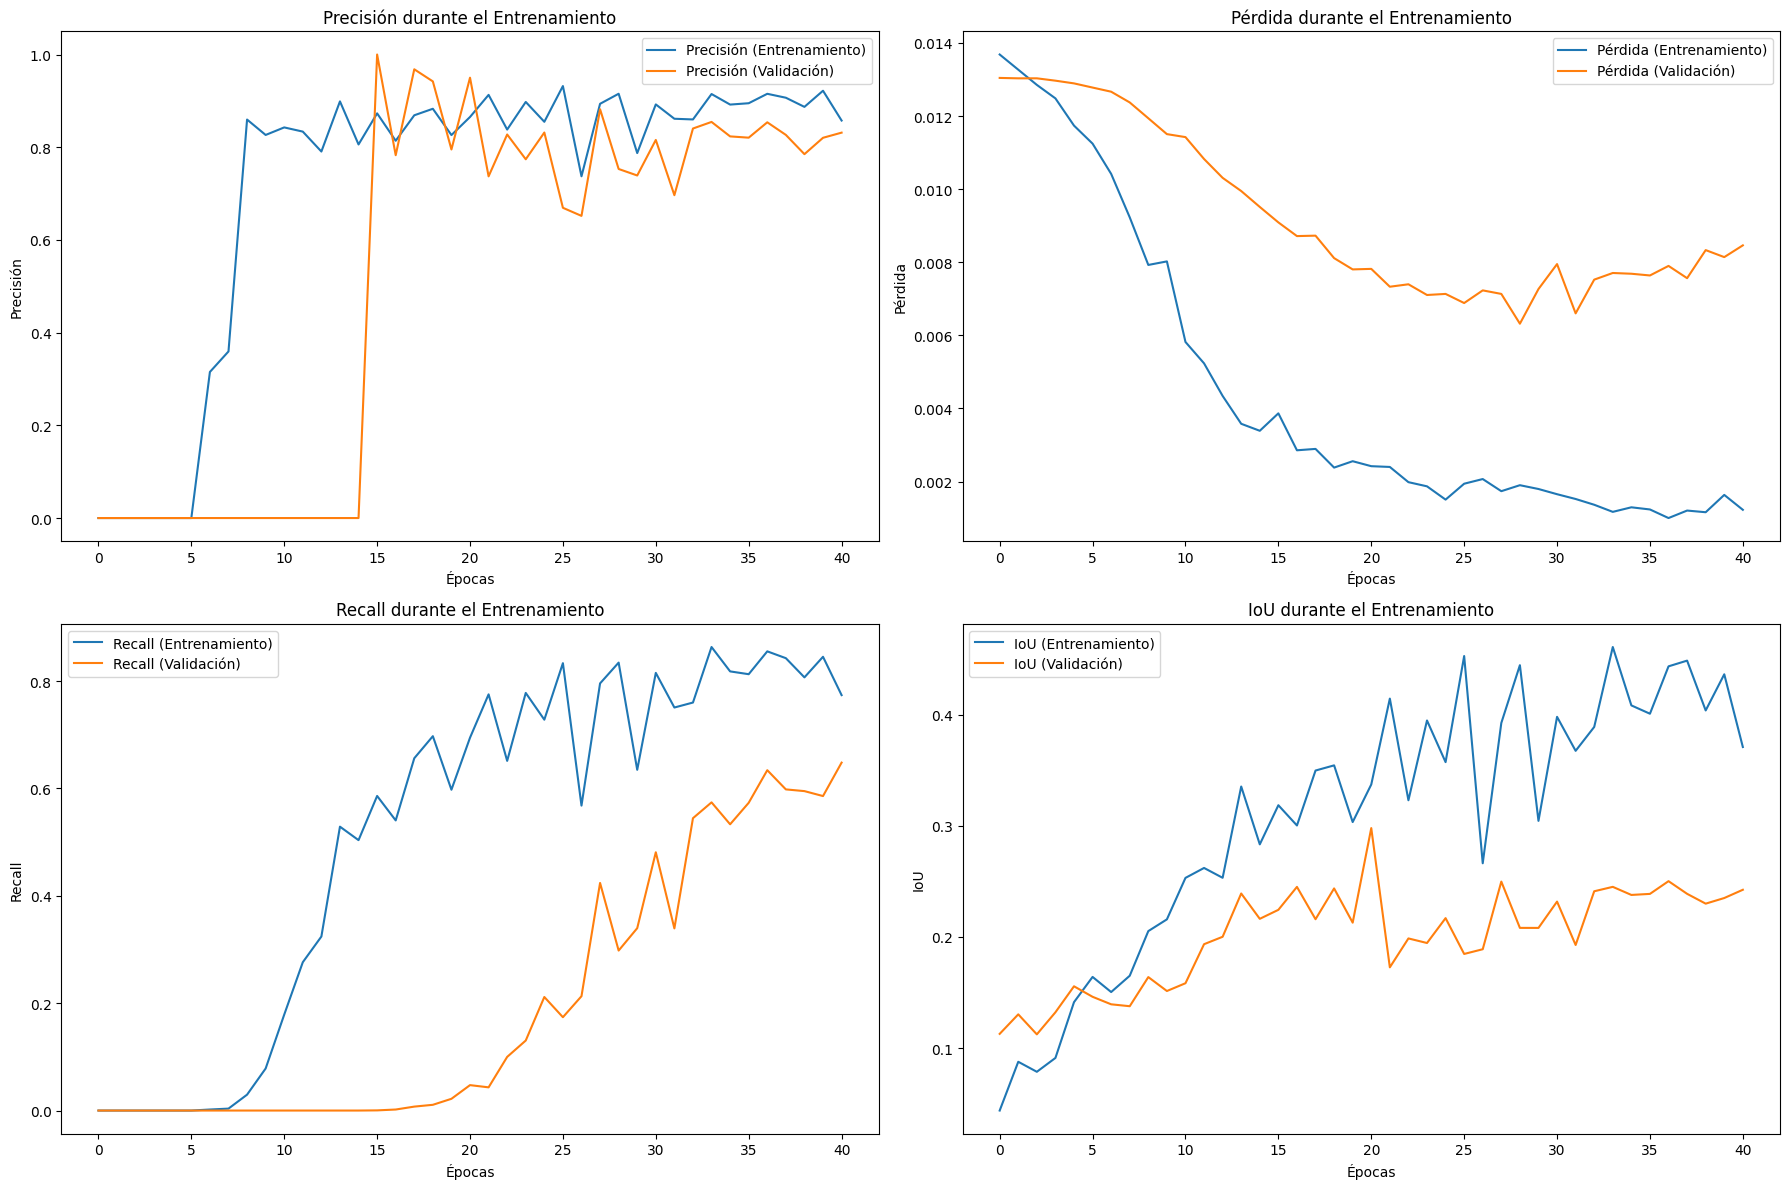

In [51]:
plot_training_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


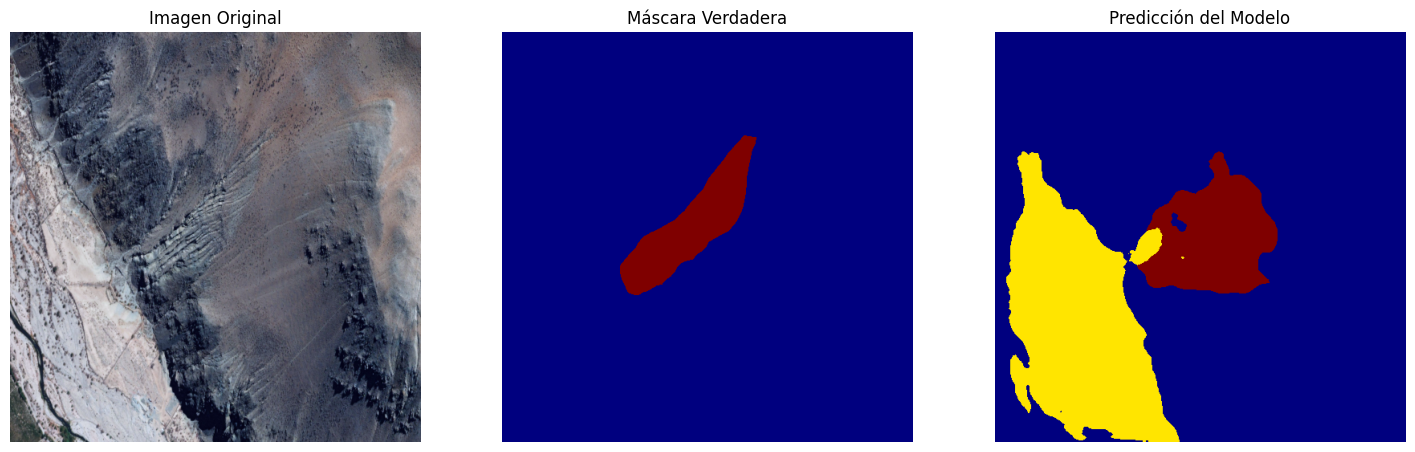

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


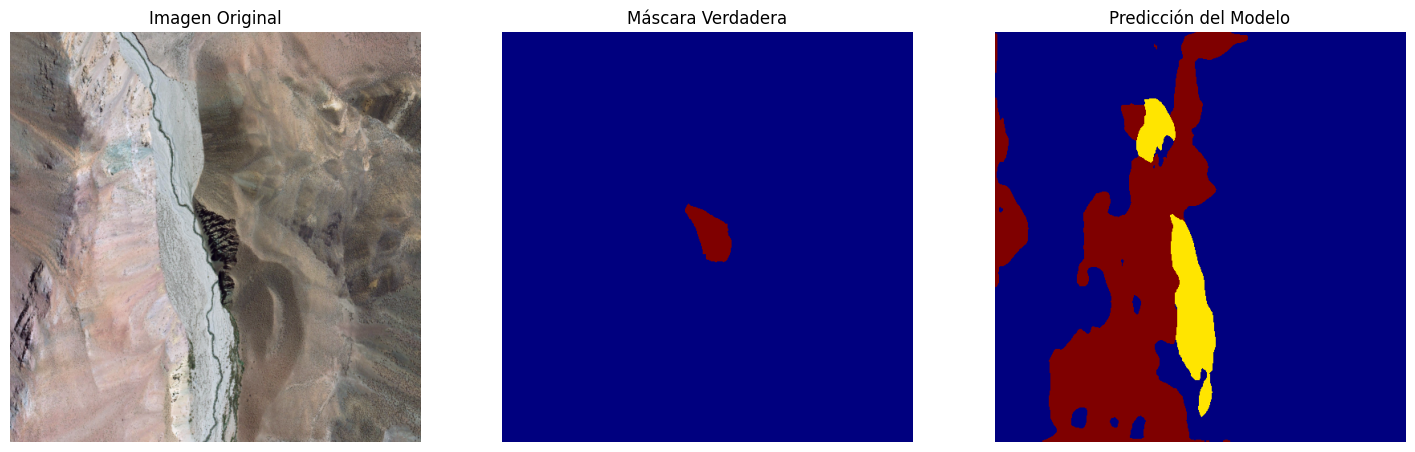

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


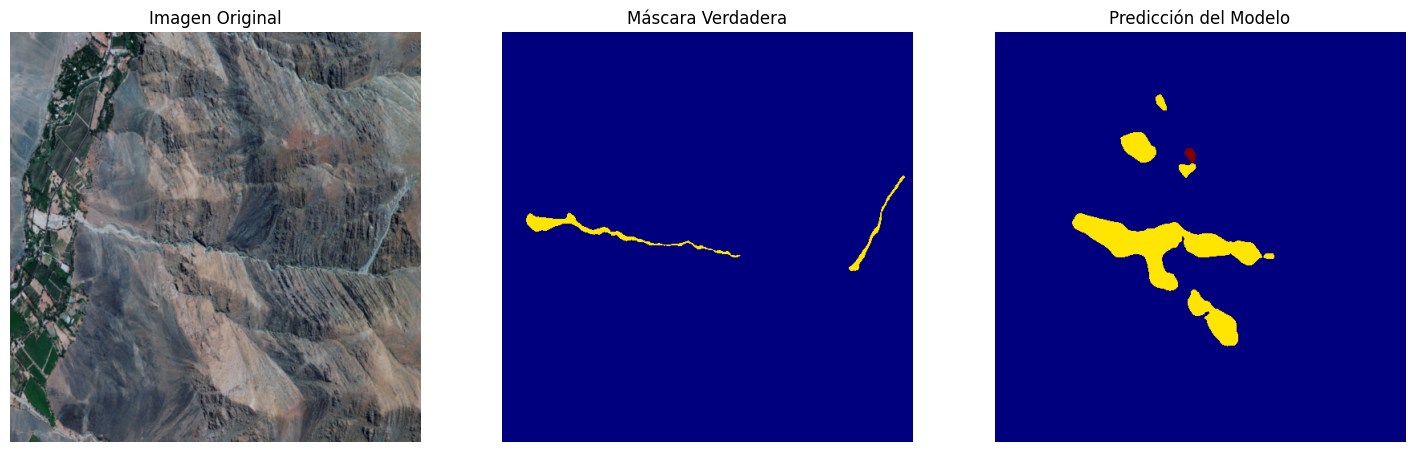

In [50]:
# Visualizar algunas predicciones
visualize_predictions(model, X_test, y_test, num_samples=3)

In [ ]:
# Visualizar solo errores en clases de remoción
def visualize_errors(model, X_test, y_test, num_samples=5):
    y_pred = model.predict(X_test)
    error_indices = []
    for i in range(len(y_test)):
        pred_class = np.argmax(y_pred[i])
        true_class = np.argmax(y_test[i])
        if pred_class != true_class and true_class != 0:  # Solo errores en clases de remoción
            error_indices.append(i)
    visualize_predictions(model, X_test[error_indices], y_test[error_indices])